# PPS Domain Scoring classifier

# Overview
PPS currently uses the **Google Detection** API in order to find uses of particular pictures through out the web. Once Google Detection has found the use cases of the image, domain data is gathered, and placed in a mongodb. Based on certain input features, a rule based scoring system is in place to determine if the domain is with pursuing to prosecute. 

# Current Rule Based Scoring
* **`essential.score.latest.score`**: the output of the scoring system (from 1 - 13, where 13 means the domain is valuable)
*  **`essential.BellonaStatus`**: first thing they go off of. Values of `SKIP_` or `HOLD_` are given scores of zero since they are not valuable. 
* **`ssential.score.latest.components.whoisScoreComponents.registrantContactCountry`**: USA gets a score of 3, some european countries, singapore, canada and austraila are given a score of 1, everything else is 0
* **`essential.score.latest.components.privateRegistrationStatus`**:  If the domain is registered privately (meaning done by a domain service, that means we can't easily determine who the owner is and thus it makes it harder prosecute, so we give these a score of 0, everything else is whatever the whois score was (which isn't zero since we already filtered those out). 
* **`essential.score.latest.components.alexaData.trafficData.ran`**:  finally, you can get a boost from alexa based on if the site is popular. Anything below 10000 gets a bonus of 10 (so for a USA site, this gives 13), and that goes down to a bonus of 2 for a score below 500000, with scores in between. 

# Idea
> Implement a supervised machine learning classification algorithm in order to better predict what domains are worth pursuing for copy right infringement

# Data
We are going to be working with input data that I manually selected/engineered. 
## Input features:
> 
* `BellonaStatus`: binary (TODO vs DONE)
* `medianLoadTime`: integer 
* `speedPercentile`: integer
* `trafficDataRank`: integer
* `trafficDataReachRank`: integer
* `reachPerMillionValue`: float 
* `pageViewsPerMillionValue`: float
* `pageViewsRankValue`: integer
* `usageStatisticRankValue`: integer
* `reachRankValue`: integer
* `historyDataScore`: integer
* `domainAge`: integer
* `registrantContactCountry`: String (USA, Canada, etc) 

## Output Classifier
>  
* `analystResult`: Boolean/Binary (TRUE or FALSE)


# Load the Data
Lets begin by calling for the usual imports, and then load our data.

In [1661]:
# standard
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1662]:
domains = pd.read_csv('PPSDomains.csv')

# Explore the Data

In [1663]:
domains.head()

domain analystResult BellonaStatus  medianLoadTime  \
0          07449m.com           NaN           NaN             NaN   
1      1037kissfm.com           NaN           NaN             NaN   
2        1041kqth.com           NaN          TODO          7687.0   
3  1049maxcountry.com           NaN           NaN             NaN   
4     1053thebuzz.com           NaN           NaN             NaN   

   speedPercentile  trafficDataRank  trafficDataReachRank  \
0              NaN              NaN                   NaN   
1              NaN              NaN                   NaN   
2              1.0        1941173.0             1872730.0   
3              NaN              NaN                   NaN   
4              NaN              NaN                   NaN   

  reachPerMillionValue pageViewsPerMillionValue  pageViewsRankValue  \
0                  NaN                      NaN                 NaN   
1                  NaN                      NaN                 NaN   
2                  0.2                     0.01           2322074.0   
3                  NaN                      NaN                 NaN   
4                  NaN                      NaN                 NaN   

   usageStatisticRankValue  reachRankValue  historyDataScore  domainAge  \
0                      NaN             NaN                 3       68.0   
1                      NaN             NaN                 3     6955.0   
2                2025813.0       2060156.0                 3     1251.0   
3                      NaN             NaN                 3      978.0   
4                      NaN             NaN                 3     6221.0   

  registrantContactCountry                          privateRegistrationStatus  
0            UNITED STATES  {"registrantName":"Domain Administrator","simi...  
1            UNITED STATES                                                NaN  
2            UNITED STATES                                                NaN  
3            UNITED STATES                                                NaN  
4            UNITED STATES                                                NaN

In [1664]:
domains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 16 columns):
domain                       2182 non-null object
analystResult                2147 non-null object
BellonaStatus                377 non-null object
medianLoadTime               516 non-null float64
speedPercentile              516 non-null float64
trafficDataRank              667 non-null float64
trafficDataReachRank         659 non-null float64
reachPerMillionValue         659 non-null object
pageViewsPerMillionValue     659 non-null object
pageViewsRankValue           659 non-null float64
usageStatisticRankValue      659 non-null float64
reachRankValue               659 non-null float64
historyDataScore             2182 non-null int64
domainAge                    2181 non-null float64
registrantContactCountry     2182 non-null object
privateRegistrationStatus    1016 non-null object
dtypes: float64(8), int64(1), object(7)
memory usage: 272.8+ KB


In [1665]:
domains.describe()

medianLoadTime  speedPercentile  trafficDataRank  trafficDataReachRank  \
count      516.000000       516.000000     6.670000e+02          6.590000e+02   
mean      2790.089147        36.858527     1.281829e+06          1.042292e+06   
std       2159.771185        22.467784     2.889064e+06          2.320096e+06   
min        505.000000         0.000000     4.300000e+01          4.000000e+01   
25%       1613.500000        18.000000     1.596200e+04          1.566250e+04   
50%       2203.000000        35.000000     9.637000e+04          8.766700e+04   
75%       3277.750000        53.250000     1.008054e+06          8.453905e+05   
max      24014.000000        95.000000     1.835996e+07          1.677951e+07   

       pageViewsRankValue  usageStatisticRankValue  reachRankValue  \
count        6.590000e+02             6.590000e+02    6.590000e+02   
mean         1.431511e+06             1.209511e+06    1.126838e+06   
std          3.007834e+06             2.674119e+06    2.554644e+06   
min          7.000000e+01             4.300000e+01    3.900000e+01   
25%          2.873000e+04             1.736600e+04    1.676150e+04   
50%          1.363660e+05             9.131800e+04    8.249100e+04   
75%          1.313736e+06             9.003270e+05    8.191410e+05   
max          1.997626e+07             1.752808e+07    1.747542e+07   

       historyDataScore    domainAge  
count       2182.000000  2181.000000  
mean           3.336389  3907.232004  
std            2.454454  2867.435646  
min            1.000000     5.000000  
25%            3.000000   952.000000  
50%            3.000000  3735.000000  
75%            3.000000  6601.000000  
max           20.000000  9607.000000

So we can see that we are working with a total of 2182 domains. Lets filter out any that do not have an `analystResult` since they will not be able to be used in training or testing our classifier.

In [1666]:
domains = domains[pd.notnull(domains['analystResult'])] 

And lets quickly convert the analystResult from being a string TRUE or FALSE, to a 1 or a 0. We can start by seeing the different ways they may have created the true and false strings.

In [1667]:
domains.analystResult.unique()

array(['FALSE', 'TRUE', 'TRUE ', 'FALSE '], dtype=object)

So we need to convert: 
> `'FALSE'` => 0, `'FALSE '` => 0, `'TRUE'` => 1, `'TRUE '` => 1
   

In [1668]:
ar = {'TRUE': 1, 'FALSE': 0, 'TRUE ': 1, 'FALSE ': 0}
domains['analystResult'] = domains['analystResult'].map(ar)

### Missing Data
Lets create a simple heatmap to see where we are missing data.

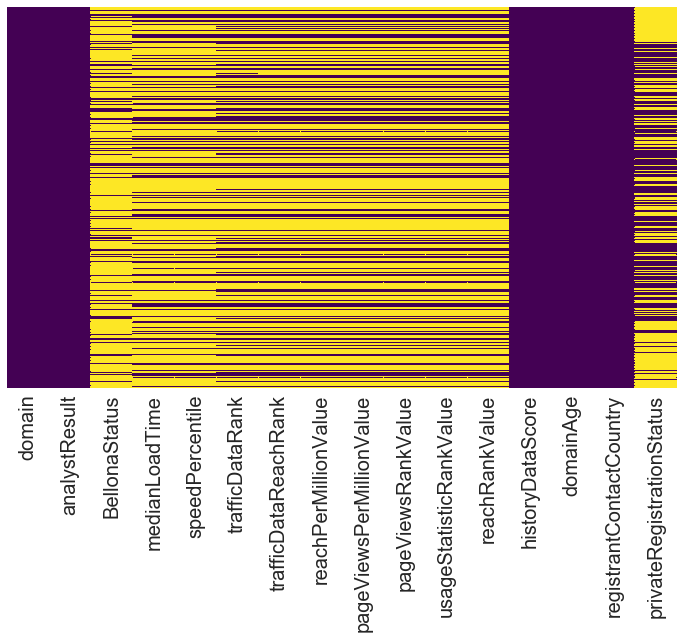

In [1669]:
plt.figure(figsize=(12,7))
sns.set(font_scale=2)
sns.heatmap(domains.isnull(), yticklabels=False, cbar=False, cmap='viridis')

What does this heat plot represent? Well the yellow lines represent a **true point**, where true means that we did **not** have any data at that data point. 

Alright so we can see that there is a good deal of data missing in this set. This may make it rather difficult to utilize (where the plot is very yellow this shows where we may run into issues). 

Lets move on to a visual analysis for now though.

### Visual Analysis
Lets start by simply getting a good count of how many domains have been marked as valuable (a TRUE value for `analystResult`).

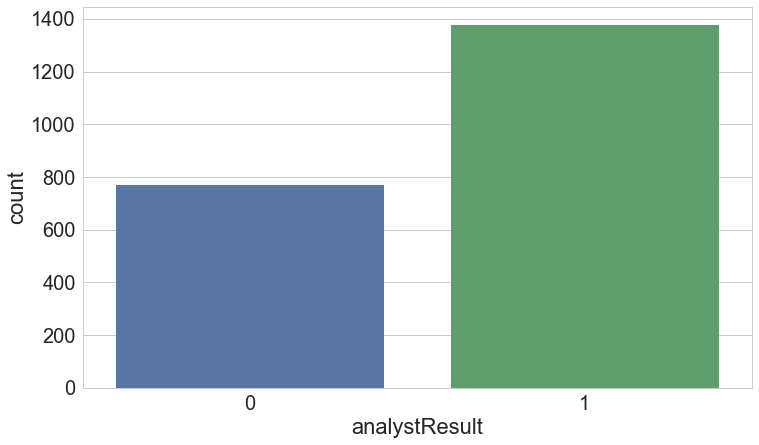

In [1670]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,7))
sns.countplot(x='analystResult', data=domains)

So it looks like currently there are ~ 1500 domains scored as worth pursuing, and ~750 that are not worth pursuing.

We can further look at pursual based on contact country.

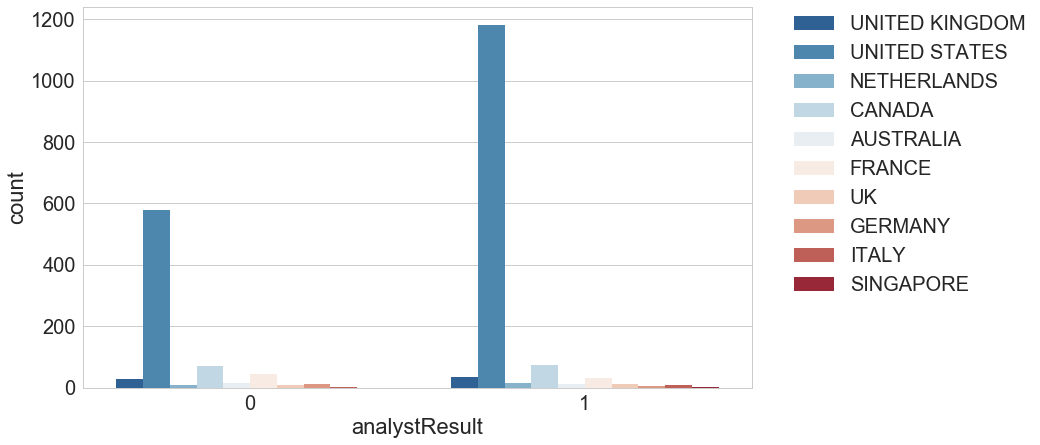

In [1671]:
plt.figure(figsize=(12,7))
sns.countplot(x='analystResult', hue='registrantContactCountry', data=domains, palette='RdBu_r')

# place legend outside of figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Clearly the vast majority of Domains are coming from the US. Lets look at another countplot, but with a hue pertaining to private registration status. In order to do that first we need to engineer the data slightly: any entry that is null for `privateRegistrationStatus` will be marked as 0 (not privately registered), and any entry with text will be given a 1. 

In [1672]:
# set any empty cells (publically registered) equal to 0
domains['privateRegistrationStatus'] = domains['privateRegistrationStatus'].replace(np.nan, 0)

# set any cells with text (privately registered) equal to 1
domains['privateRegistrationStatus'] = domains['privateRegistrationStatus'].map(lambda x: 1 if x != 0 else 0)

Now we can look at our how `analystResult` relates to `privateRegistrationStatus`.

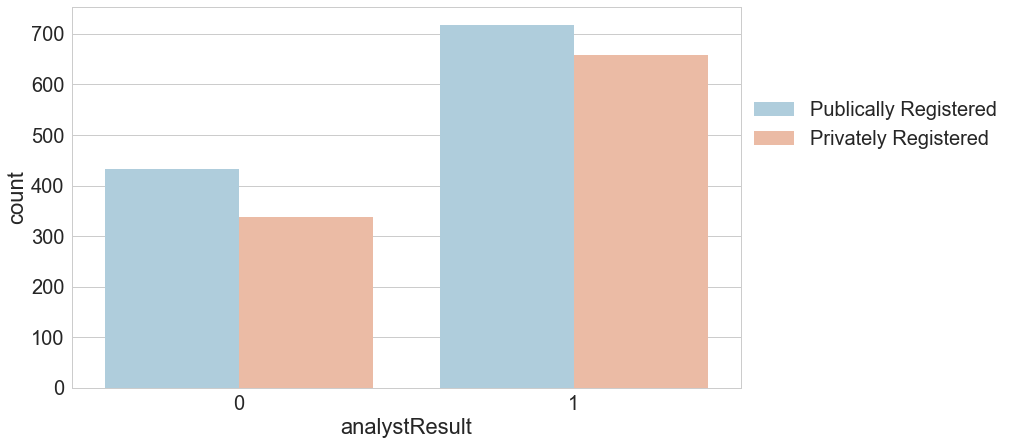

In [1673]:
plt.figure(figsize=(12,7))
sns.countplot(x='analystResult', hue='privateRegistrationStatus', data=domains, palette='RdBu_r')

# place legend outside of figure
plt.legend(['Publically Registered', 'Privately Registered'], loc=9, bbox_to_anchor=(1.2, .8))


## Statistical Analysis
Lets quickly run through the the `domainAge` input feature to see if there difference in mean between examples worth pursuing and not pursuing is statistically significant!

Lets first ensure it has been cleaned properly.

In [1674]:
# filling in any NaN values with the mean domain age
domains['domainAge'] = domains['domainAge'].fillna(domains['domainAge'].mean())

# grabbing all domain age values where the analyst result is 1
domainAgeValuable = domains[domains['analystResult'] == 1]['domainAge']

# grabbing all domain age values where the analyst result is 0
domainAgeNotValuable = domains[domains['analystResult'] == 0]['domainAge']

We now want to compare the mean of `domainAgeValuable` and `domainAgeNotValuable` and see if they are statistically significantly different. 

In [1675]:
from scipy import stats

In [1676]:
tDomainAge, pDomainAge = stats.ttest_ind(domainAgeValuable,domainAgeNotValuable)
print("t statistic:", tDomainAge,"\tp value:", pDomainAge)

t statistic: 3.70606533262 	p value: 0.000215835656588


## Data Cleaning and Normalization
Lets take another look at our heatmap to see where we are encountering the most missing data.

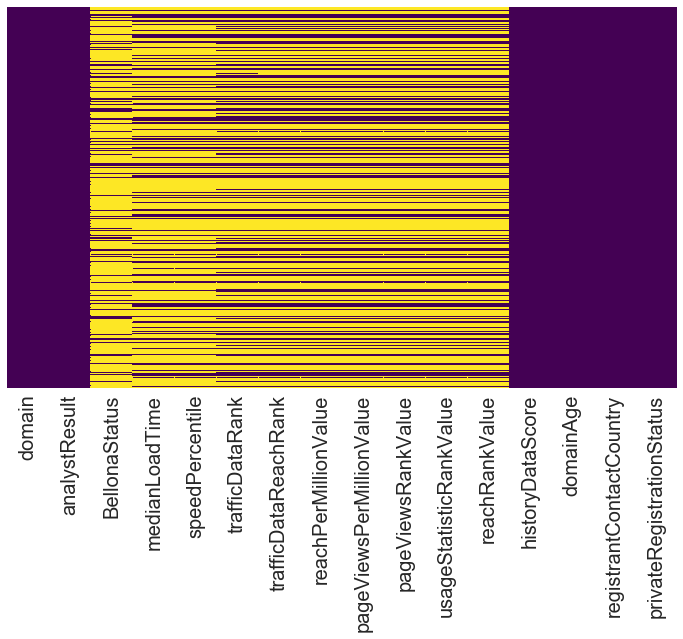

In [1677]:
plt.figure(figsize=(12,7))
sns.set(font_scale=2)
sns.heatmap(domains.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We can see that we are still missing a large amount of the data related to traffic, speed metrics, and usage statistics. At this point there are a few options:
> 
* Remove those features from the data set 
* Guessing it’s value on different factors if it’s moderately correlated with another data.
* Removing the training examples that have any feature missing
* Set missing features to the average

I am going to take the following approach:
* Drop features that will be heavily correlated
* Set all of the missing values to the mean of their input feature (for the numerical input features)
* Normalize those data sets
* Once testing out different algorithms I will then create a data set that does not include those values and then 

## Drop Columns
We are going to want to drop `historyDataScore` considering it was the result returned from the old scoring algorithm, as well as medianLoadTime and speedPercentile.

In [1678]:
domains = domains.drop(['historyDataScore','medianLoadTime','speedPercentile'], axis=1)

This brings us to `trafficDataRank` and `trafficDataReachRank`. We will drop `trafficDataReachRank` because it will be correlated with `trafficDataRank`.

In [1679]:
domains = domains.drop(['trafficDataReachRank'], axis=1)

## Statistical Test `trafficDataRank`
Now lets run a statistical test in order to see if `trafficDataRank` is statistically significant and worth keeping. 

In [1680]:
trafficDataRankDomains = domains[['analystResult', 'trafficDataRank']].dropna()

trafficValuable = trafficDataRankDomains[trafficDataRankDomains['analystResult'] == 1]['trafficDataRank'] 
trafficNotValuable = trafficDataRankDomains[trafficDataRankDomains['analystResult'] == 0]['trafficDataRank'] 
print(trafficValuable.mean(), "\t", trafficNotValuable.mean())

t, p = stats.ttest_ind(trafficValuable,trafficNotValuable)
print("t statistic:", t,"\tp value:", p)

1152989.75172 	 1469243.63274
t statistic: -1.35377903487 	p value: 0.176270981745


Based on this test, it does not look as though `trafficDataRank` is statistically significant. I am going to keep it for now, but will be sure to run our final algorithms on an input data set *with* it included, and *without* it to see its effect. 

## Statistical Test `reachPerMillionValue`
Lets run a statistical analysis on the `reachPerMillionValue` next to see if it is statistically significant. 

In [1681]:
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')

reachPerMillionValueDomains = domains[['analystResult', 'reachPerMillionValue']].dropna()
reachPerMillionValueDomains['reachPerMillionValue'] = reachPerMillionValueDomains['reachPerMillionValue'].map(atof)

rpmValuable = reachPerMillionValueDomains[reachPerMillionValueDomains['analystResult'] == 1]['reachPerMillionValue'] 
rpmNotValuable = reachPerMillionValueDomains[reachPerMillionValueDomains['analystResult'] == 0]['reachPerMillionValue'] 
print(rpmValuable.mean(), "\t", rpmNotValuable.mean())

t, p = stats.ttest_ind(rpmValuable,rpmNotValuable)
print("t statistic:", t,"\tp value:", p)

208.728601399 	 297.102276786
t statistic: -1.00103572255 	p value: 0.317181470926


Again, it looks as though it is not statistically significant based on its p value and should be dropped. 

In [1682]:
domains = domains.drop(['reachPerMillionValue'], axis=1)

## Statistical Test `pageViewsRankValue`
Lets now look at the `pageViewsRankValue`.

In [1683]:
pvrvDomains = domains[['analystResult', 'pageViewsRankValue']].dropna()

pvrvValuable = pvrvDomains[pvrvDomains['analystResult'] == 1]['pageViewsRankValue'] 
pvrvNotValuable = pvrvDomains[pvrvDomains['analystResult'] == 0]['pageViewsRankValue'] 
print(pvrvValuable.mean(), "\t", pvrvNotValuable.mean())

t, p = stats.ttest_ind(pvrvValuable,pvrvNotValuable)
print("t statistic:", t,"\tp value:", p)

1272152.14918 	 1658886.48214
t statistic: -1.58997041927 	p value: 0.11232695566


Again, not statistically significant. I will drop `pageViewsRankValue` as well as `pageViewsPerMillionValue`, `usageStatisticRankValue`, and `reachRankValue`.

In [1684]:
domains = domains.drop(['pageViewsRankValue','pageViewsPerMillionValue', 'usageStatisticRankValue', 'reachRankValue'], axis=1)

## Missing Data
Lets now fill get rid of the `NaN` values in the `bellonaStatus` column, replacing them with `0`, and replacing `DONE` with `1`.

In [1685]:
# set any cells `DONE` equal to 1
domains['BellonaStatus'] = domains['BellonaStatus'].map(lambda x: 1 if x == 'DONE' else 0)

## Impute `TrafficDataRank`
Lets now impute `trafficDataRank` with its mean value. As stated earlier, we may decide to drop this eventually, but will see how it helps the algorithm first.

In [1686]:
# set any empty cells to the mean value
domains['trafficDataRank'] = domains['trafficDataRank'].replace(np.nan, domains['trafficDataRank'].mean())

## Normalize Data
Okay now that we have the input features that we want, it is time to normalize them to help in the training process. 

In [1687]:
domains['trafficDataRank'] = (domains['trafficDataRank'] - domains['trafficDataRank'].mean())/(domains['trafficDataRank'].std())
domains['domainAge'] = (domains['domainAge'] - domains['domainAge'].mean())/(domains['domainAge'].std())

## Map `registrantContactCountry` 
Finally, we want to map `registrantContactCountry` to integers so that we can utilize the country values. 

In [1688]:
ar = {'UNITED KINGDOM': 0, 'UNITED STATES': 1, 'NETHERLANDS': 2, 'CANADA': 3, 'AUSTRALIA': 4, 'FRANCE': 5, 'UK': 6, 'GERMANY': 7, 'ITALY': 8, 'SINGAPORE': 9}  

domains['registrantContactCountry'] = domains['registrantContactCountry'].map(ar)

## Final look at our data
Lets get one more look at our current domains data to see if there is anything we missed.

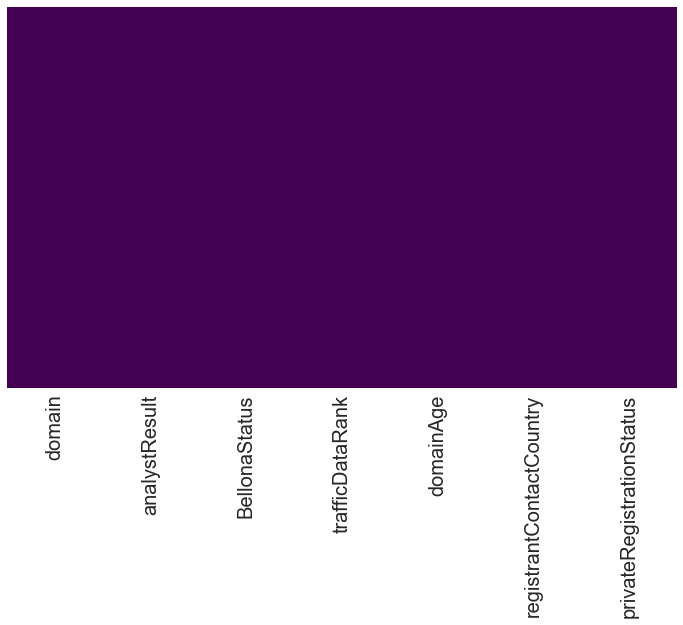

In [1689]:
plt.figure(figsize=(12,7))
sns.set(font_scale=2)
sns.heatmap(domains.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Excellent, no missed data, and a set of input features that we can work with. 

## trafficDataRank analysis
A question I had was: are domains that have alexa data associated with them more likely to be deemed as valuable. Lets look into that quickly.

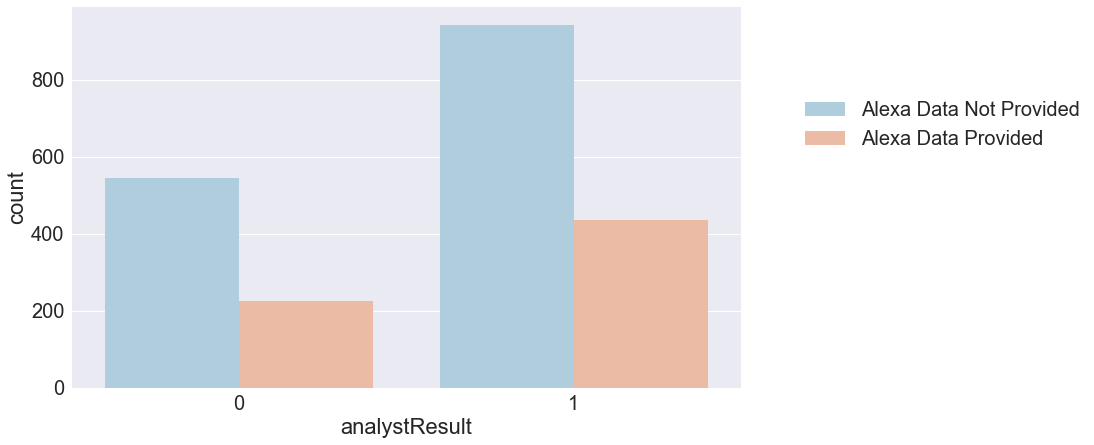

In [1690]:
domainsTDR = domains.copy()
domainsTDR['trafficDataRank'] = domainsTDR['trafficDataRank'].map(lambda x: 1 if x != 0 else 0)

plt.figure(figsize=(12,7))
sns.countplot(x='analystResult', hue='trafficDataRank', data=domainsTDR, palette='RdBu_r')

# place legend outside of figure
plt.legend(['Alexa Data Not Provided', 'Alexa Data Provided'], loc=9, bbox_to_anchor=(1.3, .8))

It can be seen from the above plot that alexa data being provided does not necessarily lead to a more valuable domain. 

# Building our Model
> 
* As I get ready to train the model there are a few things I want to remember
* create a training and test split to test for prediction accuracy
* run the algorithm with the trafficDataRank data, and without
* try several different types of algorithms (logistic regression, bayes classifier, etc)

## Create a Train Test Split
First lets grab our input features and y labels.

In [1691]:
X = domains.drop(['domain', 'analystResult', 'trafficDataRank'], axis=1)
y = domains['analystResult']

Now import `train_test_split` from `scikit-learn`.

In [1692]:
from sklearn.model_selection import train_test_split

And create the training and test set.

In [1693]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Training Models and making Predictions
Okay now that we have our training and test sets, lets actually train our model and make some predictions. 

We will start by training a logistic regression model. 

# Logistic Regression Model

In [1694]:
from sklearn.linear_model import LogisticRegression

In [1695]:
logmodel = LogisticRegression(class_weight={0: 1.5, 1: 1})
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1.5, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Now with our new model lets make some predictions!

In [1696]:
predictions = logmodel.predict(X_test)

And with our predictions made, lets evaluate them!

In [1697]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.53      0.17      0.25       240
          1       0.65      0.91      0.76       405

avg / total       0.60      0.63      0.57       645



In [1698]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions, labels=[1, 0])
cm

array([[369,  36],
       [200,  40]])

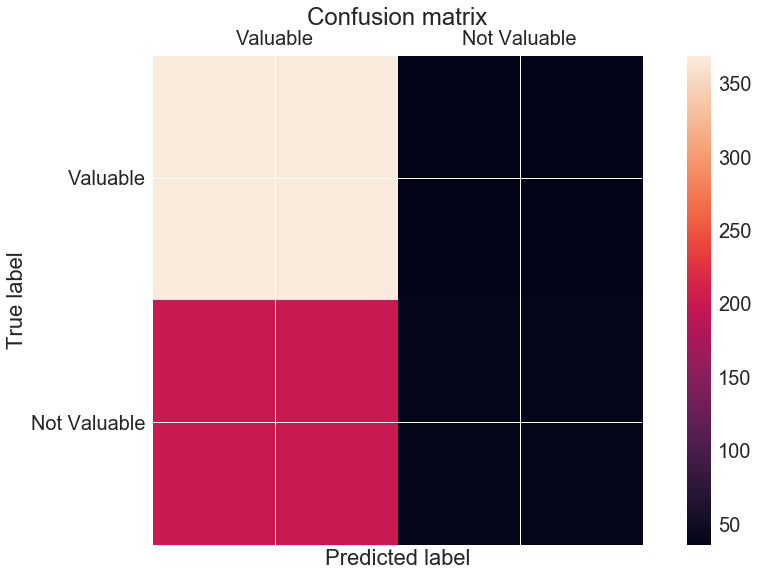

In [1718]:
plt.rcParams["figure.figsize"] = [16,9]
labels = ['Valuable', 'Not Valuable']
fig = plt.figure()
ax = fig.add_subplot(111)
color = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(color)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [1700]:
accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
accuracy

0.6341085271317829

In [1701]:
precision = cm[0,0]/(cm[0,0]+cm[1,0])
precision

0.64850615114235499

In [1702]:
recall = cm[0,0]/(cm[0,0]+cm[0,1])
recall

0.91111111111111109

# Comparison to Original Rule Based Method
Lets now go through an initial comparison between the rule based method and the logistic regression classifier. 

## Rule based metrics 
So the rule based method determined that there were **2400** domains worth pursuing. 

In [1703]:
arTrue = domains['analystResult'].sum()
arFalse = domains['analystResult'].count() - domains['analystResult'].sum()
print("Rule Based Analyst result true: ", arTrue)
print("Rule Based Analyst result false: ", arFalse)

Rule Based Analyst result true:  1376
Rule Based Analyst result false:  771


### Precision

In [1704]:
precision = arTrue/(arTrue + arFalse)
print("Precision: ", precision)

Precision:  0.640894271076
